# Raw Material Delivery Forecasting Pipeline

## Task Overview
Predict cumulative weight of incoming raw material deliveries from January 1, 2025 to various end dates (up to May 31, 2025).

## Evaluation Metric
Quantile Loss at 0.2 (asymmetric loss that penalizes overestimation more than underestimation)

## Strategy
- Conservative predictions (better to underestimate than overestimate)
- Time series forecasting with feature engineering
- Leverage purchase orders and historical patterns

## 1. Setup and Data Loading

In [34]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [35]:
# Load data files
# Update these paths based on your local setup
DATA_PATH = '../data/'  # Adjust this path as needed

# Primary data
receivals = pd.read_csv(f'{DATA_PATH}kernel/receivals.csv')
purchase_orders = pd.read_csv(f'{DATA_PATH}kernel/purchase_orders.csv')

# Optional extended data
try:
    materials = pd.read_csv(f'{DATA_PATH}extended/materials.csv')
    transportation = pd.read_csv(f'{DATA_PATH}extended/transportation.csv')
    print("Extended data loaded successfully")
except:
    materials = None
    transportation = None
    print("Extended data not available")

# Prediction mapping and sample submission
prediction_mapping = pd.read_csv(f'{DATA_PATH}prediction_mapping.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

print(f"Receivals shape: {receivals.shape}")
print(f"Purchase orders shape: {purchase_orders.shape}")
print(f"Prediction mapping shape: {prediction_mapping.shape}")

Extended data loaded successfully
Receivals shape: (122590, 10)
Purchase orders shape: (33171, 12)
Prediction mapping shape: (30450, 4)


## 2. Data Exploration and Preprocessing

In [36]:
# Display basic information
print("=" * 80)
print("RECEIVALS DATA")
print("=" * 80)
print(receivals.head())
print("\nData types:")
print(receivals.dtypes)
print("\nMissing values:")
print(receivals.isnull().sum())
print("\nBasic statistics:")
print(receivals.describe())

RECEIVALS DATA
   rm_id  product_id  purchase_order_id  purchase_order_item_no  \
0  365.0  91900143.0           208545.0                    10.0   
1  365.0  91900143.0           208545.0                    10.0   
2  365.0  91900143.0           208490.0                    10.0   
3  365.0  91900143.0           208490.0                    10.0   
4  379.0  91900296.0           210435.0                    20.0   

   receival_item_no  batch_id                date_arrival receival_status  \
0                 1       NaN  2004-06-15 13:34:00 +02:00       Completed   
1                 2       NaN  2004-06-15 13:34:00 +02:00       Completed   
2                 1       NaN  2004-06-15 13:38:00 +02:00       Completed   
3                 2       NaN  2004-06-15 13:38:00 +02:00       Completed   
4                 1       NaN  2004-06-15 13:40:00 +02:00       Completed   

   net_weight  supplier_id  
0     11420.0        52062  
1     13760.0        52062  
2     11281.0        50468  
3  

In [37]:
# Convert date columns to datetime
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True).dt.tz_localize(None)
purchase_orders['modified_date_time'] = pd.to_datetime(purchase_orders['modified_date_time'], utc=True).dt.tz_localize(None)

# Convert prediction mapping dates
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print("Date conversion completed")
print(f"Receivals date range: {receivals['date_arrival'].min()} to {receivals['date_arrival'].max()}")
print(f"Number of unique raw materials: {receivals['rm_id'].nunique()}")

Date conversion completed
Receivals date range: 2004-06-15 11:34:00 to 2024-12-19 13:36:00
Number of unique raw materials: 203


In [38]:
# Analyze prediction requirements
print("Prediction Requirements:")
print(f"Unique raw materials to predict: {prediction_mapping['rm_id'].nunique()}")
print(f"Total predictions needed: {len(prediction_mapping)}")
print(f"\nForecast date range:")
print(f"  Start: {prediction_mapping['forecast_start_date'].min()}")
print(f"  End: {prediction_mapping['forecast_end_date'].max()}")
print(f"\nForecast horizons (days):")
prediction_mapping['forecast_horizon'] = (prediction_mapping['forecast_end_date'] - 
                                           prediction_mapping['forecast_start_date']).dt.days + 1
print(prediction_mapping['forecast_horizon'].describe())

Prediction Requirements:
Unique raw materials to predict: 203
Total predictions needed: 30450

Forecast date range:
  Start: 2025-01-01 00:00:00
  End: 2025-05-31 00:00:00

Forecast horizons (days):
count    30450.000000
mean        76.500000
std         43.301019
min          2.000000
25%         39.000000
50%         76.500000
75%        114.000000
max        151.000000
Name: forecast_horizon, dtype: float64


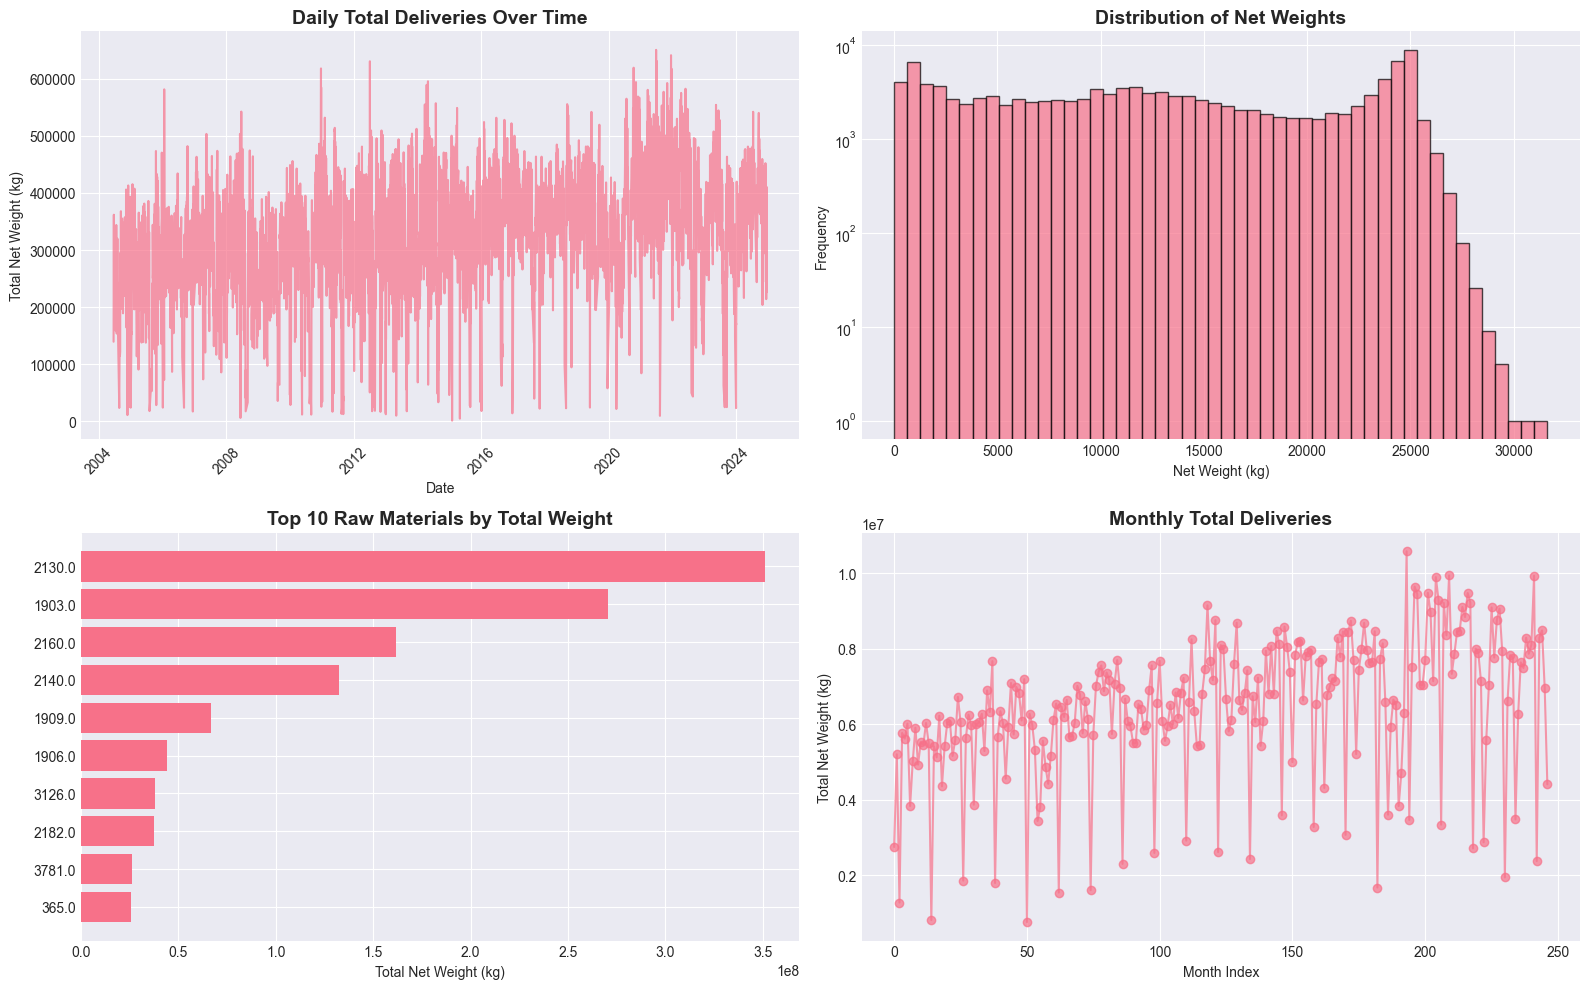

In [39]:
# Visualize delivery patterns over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Daily deliveries over time
daily_deliveries = receivals.groupby(receivals['date_arrival'].dt.date)['net_weight'].sum()
axes[0, 0].plot(daily_deliveries.index, daily_deliveries.values, alpha=0.7)
axes[0, 0].set_title('Daily Total Deliveries Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Net Weight (kg)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribution of net weights
axes[0, 1].hist(receivals['net_weight'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Net Weights', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Net Weight (kg)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# Top 10 raw materials by total weight
top_materials = receivals.groupby('rm_id')['net_weight'].sum().nlargest(10)
axes[1, 0].barh(range(len(top_materials)), top_materials.values)
axes[1, 0].set_yticks(range(len(top_materials)))
axes[1, 0].set_yticklabels(top_materials.index)
axes[1, 0].set_title('Top 10 Raw Materials by Total Weight', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Net Weight (kg)')
axes[1, 0].invert_yaxis()

# Deliveries per month
receivals['year_month'] = receivals['date_arrival'].dt.to_period('M')
monthly_deliveries = receivals.groupby('year_month')['net_weight'].sum()
axes[1, 1].plot(range(len(monthly_deliveries)), monthly_deliveries.values, marker='o', alpha=0.7)
axes[1, 1].set_title('Monthly Total Deliveries', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month Index')
axes[1, 1].set_ylabel('Total Net Weight (kg)')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [40]:
def create_historical_features(receivals_df, end_date, rm_id):
    """
    Create historical features for a specific raw material up to a given date.
    
    Parameters:
    - receivals_df: DataFrame with receival data (columns: rm_id, date_arrival, net_weight)
    - end_date: End date for feature calculation
    - rm_id: Raw material ID
    
    Returns:
    - Dictionary of features
    """
    features = {}
    
    # Filter data for this raw material up to end_date
    rm_data = receivals_df[(receivals_df['rm_id'] == rm_id) & 
                           (receivals_df['date_arrival'] < end_date)].copy()
    
    if len(rm_data) == 0:
        # No historical data available: return default values
        features.update({
            'avg_janmay_3y': 0,
            'avg_janmay_5y': 0,
            'last_year_janmay': 0,
            'last_year_total': 0,
            'janmay_growth_rate': 0,
            'weight_3mo': 0, 'weight_6mo': 0, 'weight_12mo': 0,
            'daily_avg_3mo': 0, 'daily_avg_6mo': 0, 'daily_avg_12mo': 0,
            'trend_3mo_vs_6mo': 0, 'trend_6mo_vs_12mo': 0,
            'weight_std_3mo': 0, 'weight_cv_3mo': 0,
            'median_delivery_3mo': 0, 'max_delivery_3mo': 0,
            'days_since_last_delivery': 999,
            'deliveries_count_3mo': 0, 'deliveries_count_6mo': 0, 'deliveries_count_12mo': 0,
            'avg_days_between_deliveries': 999
        })
        return features
    
    # -------------------- SEASONAL FEATURES --------------------
    year_end = end_date.year
    janmay_mask = rm_data['date_arrival'].dt.month.isin([1,2,3,4,5])
    
    # Average Jan-May last 3 and 5 years
    avg_janmay_3y = rm_data[janmay_mask & (rm_data['date_arrival'].dt.year >= year_end-3)]['net_weight'].mean()
    avg_janmay_5y = rm_data[janmay_mask & (rm_data['date_arrival'].dt.year >= year_end-5)]['net_weight'].mean()
    
    # Last year Jan-May
    last_year_mask = rm_data['date_arrival'].dt.year == (year_end - 1)
    last_year_janmay = rm_data[last_year_mask & rm_data['date_arrival'].dt.month.isin([1,2,3,4,5])]['net_weight'].sum()
    
    # Last year total
    last_year_total = rm_data[last_year_mask]['net_weight'].sum()
    
    # Jan-May growth rate (recent 2y vs older 2y)
    recent_avg = rm_data[janmay_mask & rm_data['date_arrival'].dt.year.isin([year_end-1, year_end-2])]['net_weight'].mean()
    older_avg = rm_data[janmay_mask & rm_data['date_arrival'].dt.year.isin([year_end-3, year_end-4])]['net_weight'].mean()
    janmay_growth_rate = (recent_avg - older_avg) / (older_avg + 1)
    
    features.update({
        'avg_janmay_3y': avg_janmay_3y,
        'avg_janmay_5y': avg_janmay_5y,
        'last_year_janmay': last_year_janmay,
        'last_year_total': last_year_total,
        'janmay_growth_rate': janmay_growth_rate
    })
    
    # -------------------- TREND FEATURES --------------------
    def calc_trend(days):
        start_date = end_date - pd.Timedelta(days=days)
        period_data = rm_data[rm_data['date_arrival'] >= start_date]
        total_weight = period_data['net_weight'].sum()
        daily_avg = total_weight / days
        return total_weight, daily_avg, len(period_data)
    
    weight_3mo, daily_avg_3mo, deliveries_3mo = calc_trend(90)
    weight_6mo, daily_avg_6mo, deliveries_6mo = calc_trend(180)
    weight_12mo, daily_avg_12mo, deliveries_12mo = calc_trend(365)
    
    features.update({
        'weight_3mo': weight_3mo, 'weight_6mo': weight_6mo, 'weight_12mo': weight_12mo,
        'daily_avg_3mo': daily_avg_3mo, 'daily_avg_6mo': daily_avg_6mo, 'daily_avg_12mo': daily_avg_12mo,
        'trend_3mo_vs_6mo': daily_avg_3mo - daily_avg_6mo,
        'trend_6mo_vs_12mo': daily_avg_6mo - daily_avg_12mo
    })
    
    # -------------------- VARIABILITY FEATURES --------------------
    last_3mo_data = rm_data[rm_data['date_arrival'] >= (end_date - pd.Timedelta(days=90))]
    weight_std_3mo = last_3mo_data['net_weight'].std() if len(last_3mo_data) > 1 else 0
    weight_cv_3mo = weight_std_3mo / (last_3mo_data['net_weight'].mean() + 1) if len(last_3mo_data) > 0 else 0
    median_delivery_3mo = last_3mo_data['net_weight'].median() if len(last_3mo_data) > 0 else 0
    max_delivery_3mo = last_3mo_data['net_weight'].max() if len(last_3mo_data) > 0 else 0
    
    features.update({
        'weight_std_3mo': weight_std_3mo,
        'weight_cv_3mo': weight_cv_3mo,
        'median_delivery_3mo': median_delivery_3mo,
        'max_delivery_3mo': max_delivery_3mo
    })
    
    # -------------------- RECENCY & FREQUENCY FEATURES --------------------
    all_dates = rm_data['date_arrival'].sort_values()
    days_since_last_delivery = (end_date - all_dates.max()).days
    delivery_gaps = all_dates.diff().dt.days.dropna()
    avg_days_between_deliveries = delivery_gaps.median() if len(delivery_gaps) > 0 else 999
    
    features.update({
        'days_since_last_delivery': days_since_last_delivery,
        'deliveries_count_3mo': deliveries_3mo,
        'deliveries_count_6mo': deliveries_6mo,
        'deliveries_count_12mo': deliveries_12mo,
        'avg_days_between_deliveries': avg_days_between_deliveries
    })
    
    return features


In [41]:
def create_purchase_order_features(merged_df, end_date, rm_id):
    """
    Create features from purchase orders for a specific raw material.
    
    Parameters:
    - purchase_orders_df: DataFrame with purchase order data (product_id, created_date_time, delivery_date, quantity, status)
    - receivals_df: DataFrame with receival data (rm_id, product_id, date_arrival, net_weight, po_id)
    - end_date: End date for feature calculation
    - rm_id: Raw material ID
    
    Returns:
    - Dictionary of features
    """
    features = {}
    
    # Num unique POs in purchase_orders_df
    total_pos = merged_df['product_id_po'].nunique()
    
    # filter data with this rm_id
    rm_data = merged_df[(merged_df['rm_id'] == rm_id) & (merged_df['date_arrival'] < end_date)].copy()
    
    if len(rm_data) == 0:
        # Defaults if no PO data
        features.update({
            'po_coverage_rate': 0,
            'avg_delivery_delay': 0,
            'avg_order_to_receival': 0,
            'po_fulfillment_rate': 0,
            'closed_order_rate': 0,
            'active_po_count': 0,
            'active_po_total_quantity': 0,
            'active_po_avg_quantity': 0,
            'po_expected_delivery_days': 999,
            'po_closed_rate_3mo': 0,
            'po_avg_quantity_3mo': 0
        })
        return features
    
    # -------------------- Historical PO Features --------------------
    # po_coverage_rate: proportion of receivals linked to POs
    po_coverage_rate = rm_data['product_id_rm'].notna().mean()
    
    
    # avg_delivery_delay: mean(date_arrival - delivery_date) in days
    avg_delivery_delay = (rm_data['date_arrival'] - rm_data['delivery_date']).dt.days.mean()
    
    # avg_order_to_receival: mean(date_arrival - created_date_time) in days
    avg_order_to_receival = (rm_data['date_arrival'] - rm_data['created_date_time']).dt.days.mean()
    
    # po_fulfillment_rate: unique POs that had deliveries / total POs
    fulfilled_pos = rm_data['product_id_rm'].nunique()
    po_fulfillment_rate = fulfilled_pos / total_pos if total_pos > 0 else 0
    
    # closed_order_rate: proportion of PO-linked receivals from "Closed" orders
    closed_pos = rm_data[rm_data['status'].str.lower() == 'closed']['product_id_rm'].unique()
    closed_order_rate = len(rm_data[rm_data['product_id_rm'].isin(closed_pos)]) / len(rm_data) if len(rm_data) > 0 else 0

    # -------------------- Forward-Looking PO Features --------------------
    # Active POs: created <= end_date & delivery_date >= end_date
    active_pos = rm_data[(rm_data['created_date_time'] <= end_date) & (rm_data['delivery_date'] >= end_date)]
    active_po_count = len(active_pos)
    active_po_total_quantity = active_pos['quantity'].sum()
    active_po_avg_quantity = active_pos['quantity'].mean() if active_po_count > 0 else 0
    
    # Days until nearest expected delivery from active POs
    if active_po_count > 0:
        po_expected_delivery_days = (active_pos['delivery_date'] - end_date).dt.days.min()
    else:
        po_expected_delivery_days = 999
    
    # Historical 3-month PO stats
    last_3mo_pos = rm_data[(rm_data['created_date_time'] >= end_date - pd.Timedelta(days=90)) & (rm_data['created_date_time'] < end_date)]
    po_closed_rate_3mo = len(last_3mo_pos[last_3mo_pos['status'].str.lower()=='closed']) / len(last_3mo_pos) if len(last_3mo_pos) > 0 else 0
    po_avg_quantity_3mo = last_3mo_pos['quantity'].mean() if len(last_3mo_pos) > 0 else 0
    
    # -------------------- Aggregate Features --------------------
    features.update({
        'po_coverage_rate': po_coverage_rate,
        'avg_delivery_delay': avg_delivery_delay,
        'avg_order_to_receival': avg_order_to_receival,
        'po_fulfillment_rate': po_fulfillment_rate,
        'closed_order_rate': closed_order_rate,
        'active_po_count': active_po_count,
        'active_po_total_quantity': active_po_total_quantity,
        'active_po_avg_quantity': active_po_avg_quantity,
        'po_expected_delivery_days': po_expected_delivery_days,
        'po_closed_rate_3mo': po_closed_rate_3mo,
        'po_avg_quantity_3mo': po_avg_quantity_3mo
    })
    
    return features


In [42]:
def create_stability_features(receivals_df, end_date, rm_id):
    """
    Create stability features for a specific raw material up to a given date.
    
    Parameters:
    - receivals_df: DataFrame with receival data (rm_id, date_arrival, net_weight)
    - end_date: End date for feature calculation
    - rm_id: Raw material ID
    
    Returns:
    - Dictionary of features
    """
    features = {}
    
    # Filter data for this raw material up to end_date
    rm_data = receivals_df[(receivals_df['rm_id'] == rm_id) &
                           (receivals_df['date_arrival'] < end_date)].copy()
    
    if len(rm_data) == 0:
        features['has_regular_pattern'] = 0
        features['years_active'] = 0
        return features
    
    # Calculate deliveries in last 12 months
    last_year_data = rm_data[rm_data['date_arrival'] >= (end_date - pd.Timedelta(days=365))]
    deliveries_count_last_year = len(last_year_data)
    
    # CV (coefficient of variation) over last year
    weight_mean = last_year_data['net_weight'].mean() if deliveries_count_last_year > 0 else 0
    weight_std = last_year_data['net_weight'].std() if deliveries_count_last_year > 1 else 0
    weight_cv = weight_std / (weight_mean + 1)
    
    # has_regular_pattern: >=4 deliveries in last year AND CV < 2.0
    has_regular_pattern = int((deliveries_count_last_year >= 4) and (weight_cv < 2.0))
    
    # years_active: time between first and last delivery
    first_delivery = rm_data['date_arrival'].min()
    last_delivery = rm_data['date_arrival'].max()
    years_active = (last_delivery - first_delivery).days / 365.25 if first_delivery != last_delivery else 0
    
    features['has_regular_pattern'] = has_regular_pattern
    features['years_active'] = years_active
    
    return features


In [43]:
def create_temporal_features(date):
    """
    Create temporal features from a date.
    
    Parameters:
    - date: pandas Timestamp
    
    Returns:
    - Dictionary of features
    """
    features = {}
    features['month'] = date.month
    features['quarter'] = date.quarter
    features['day_of_week'] = date.dayofweek
    features['day_of_month'] = date.day
    features['day_of_year'] = date.dayofyear
    features['week_of_year'] = date.isocalendar()[1]
    features['is_weekend'] = 1 if date.dayofweek >= 5 else 0
    features['is_month_start'] = 1 if date.day <= 7 else 0
    features['is_month_end'] = 1 if date.day >= 24 else 0
    features['is_quarter_start'] = 1 if date.month in [1, 4, 7, 10] and date.day <= 7 else 0
    features['is_quarter_end'] = 1 if date.month in [3, 6, 9, 12] and date.day >= 24 else 0
    
    return features

## 4. Prepare Training Data

We'll create a training dataset by simulating historical predictions. For each date in 2024, we'll predict cumulative deliveries for various future horizons.

In [44]:
def prepare_training_data(receivals_df, purchase_orders_df, 
                         train_start='2023-01-01', train_end='2024-12-31',
                         forecast_horizons=[7, 14, 30, 60, 90, 120, 151]):
    """
    Prepare training data with features and targets.
    
    Parameters:
    - receivals_df: DataFrame with receival data
    - purchase_orders_df: DataFrame with purchase order data
    - train_start: Start date for training period
    - train_end: End date for training period
    - forecast_horizons: List of forecast horizons (days)
    
    Returns:
    - DataFrame with features and targets
    """
    print("Preparing training data...")
    
    train_data = []
    
    # Get unique raw materials that we need to predict
    unique_rms = receivals_df['rm_id'].unique()
    
    # Sample dates for training (monthly to reduce computation)
    date_range = pd.date_range(start=train_start, end=train_end, freq='MS')  # Month start
    
    total_combinations = len(unique_rms) * len(date_range) * len(forecast_horizons)
    print(f"Generating {total_combinations:,} training samples...")
    
    merged_df = receivals_df.merge(purchase_orders_df, on=['purchase_order_id', 'purchase_order_item_no'], how='left', suffixes=('_rm', '_po'))
    
    counter = 0
    for rm_id in unique_rms:
        for forecast_date in date_range:
            for horizon in forecast_horizons:
                counter += 1
                if counter % 10000 == 0:
                    print(f"  Processed {counter:,} / {total_combinations:,} samples ({100*counter/total_combinations:.1f}%)")
                
                # Calculate target: cumulative weight from forecast_date to forecast_date + horizon
                end_date = forecast_date + pd.Timedelta(days=horizon)
                target_data = receivals_df[
                    (receivals_df['rm_id'] == rm_id) &
                    (receivals_df['date_arrival'] >= forecast_date) &
                    (receivals_df['date_arrival'] <= end_date)
                ]
                target = target_data['net_weight'].sum()
                
                # Create features (using data up to forecast_date)
                features = {}
                features['rm_id'] = rm_id
                features['forecast_date'] = forecast_date
                features['forecast_horizon'] = horizon
                
                # Historical features
                hist_features = create_historical_features(receivals_df, forecast_date, rm_id)
                features.update(hist_features)
                
                # Purchase order features
                po_features = create_purchase_order_features(merged_df, 
                                                            forecast_date, rm_id)
                features.update(po_features)
                
                # Stability features
                stab_features = create_stability_features(receivals_df, forecast_date, rm_id)
                features.update(stab_features)
                
                # Temporal features
                temp_features = create_temporal_features(forecast_date)
                features.update(temp_features)
                
                # Target
                features['target'] = target
                
                train_data.append(features)
    
    print(f"Training data preparation complete: {len(train_data):,} samples")
    return pd.DataFrame(train_data)

In [ ]:
# Prepare training data
# Note: This may take several minutes depending on data size
# Adjust date range if needed for faster testing
train_df = prepare_training_data(
    receivals, 
    purchase_orders,
    train_start='2023-06-01',  # Start from mid-2023 for faster training
    train_end='2024-11-30',     # End before 2025
    forecast_horizons=[7, 14, 30, 60, 90, 120, 151]
)

print(f"\nTraining data shape: {train_df.shape}")
print(f"\nTraining data preview:")
print(train_df.head())
print(f"\nTarget statistics:")
print(train_df['target'].describe())

Preparing training data...
Generating 25,704 training samples...
  Processed 10,000 / 25,704 samples (38.9%)
  Processed 20,000 / 25,704 samples (77.8%)
Training data preparation complete: 25,704 samples

Training data shape: (25704, 50)

Training data preview:
   rm_id forecast_date  forecast_horizon  avg_janmay_3y  avg_janmay_5y  \
0  365.0    2023-06-01                 7            NaN            NaN   
1  365.0    2023-06-01                14            NaN            NaN   
2  365.0    2023-06-01                30            NaN            NaN   
3  365.0    2023-06-01                60            NaN            NaN   
4  365.0    2023-06-01                90            NaN            NaN   

   last_year_janmay  last_year_total  janmay_growth_rate  weight_3mo  \
0               0.0              0.0                 NaN         0.0   
1               0.0              0.0                 NaN         0.0   
2               0.0              0.0                 NaN         0.0   
3    

In [1]:
train_df

NameError: name 'train_df' is not defined

In [46]:
# Save training data for future use
train_df.to_csv('training_data.csv', index=False)
print("Training data saved to 'training_data.csv'")

Training data saved to 'training_data.csv'


## 5. Model Training

We'll train a quantile regression model to predict the lower quantile (conservative predictions).

In [47]:
# Prepare features and target
feature_columns = [col for col in train_df.columns if col not in 
                   ['rm_id', 'forecast_date', 'target']]

X = train_df[feature_columns]
y = train_df['target']

print(f"Feature columns ({len(feature_columns)}):")
print(feature_columns)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Feature columns (47):
['forecast_horizon', 'avg_janmay_3y', 'avg_janmay_5y', 'last_year_janmay', 'last_year_total', 'janmay_growth_rate', 'weight_3mo', 'weight_6mo', 'weight_12mo', 'daily_avg_3mo', 'daily_avg_6mo', 'daily_avg_12mo', 'trend_3mo_vs_6mo', 'trend_6mo_vs_12mo', 'weight_std_3mo', 'weight_cv_3mo', 'median_delivery_3mo', 'max_delivery_3mo', 'days_since_last_delivery', 'deliveries_count_3mo', 'deliveries_count_6mo', 'deliveries_count_12mo', 'avg_days_between_deliveries', 'po_coverage_rate', 'avg_delivery_delay', 'avg_order_to_receival', 'po_fulfillment_rate', 'closed_order_rate', 'active_po_count', 'active_po_total_quantity', 'active_po_avg_quantity', 'po_expected_delivery_days', 'po_closed_rate_3mo', 'po_avg_quantity_3mo', 'has_regular_pattern', 'years_active', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end']

Feature matrix shape: (25704, 47)
Target shape: (2

In [48]:
# Split data chronologically
split_date = pd.Timestamp('2024-09-01')
train_mask = train_df['forecast_date'] < split_date
val_mask = train_df['forecast_date'] >= split_date

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

print(f"Training set size: {len(X_train):,}")
print(f"Validation set size: {len(X_val):,}")

Training set size: 21,420
Validation set size: 4,284


In [49]:
def quantile_loss(y_true, y_pred, q=0.2):
    """
    Calculate quantile loss for evaluation.
    """
    diff = y_true - y_pred
    return np.mean(np.maximum(q * diff, (q - 1) * diff))

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance with multiple metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    q_loss = quantile_loss(y_true, y_pred, q=0.2)
    
    print(f"\n{model_name} Performance:")
    print(f"  MAE: {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  Quantile Loss (0.2): {q_loss:,.2f}")
    
    return {'mae': mae, 'rmse': rmse, 'quantile_loss': q_loss}

In [50]:
# Train LightGBM model with quantile objective
print("Training LightGBM model with quantile objective (alpha=0.2)...")

# LightGBM parameters for quantile regression
params = {
    'objective': 'quantile',
    'alpha': 0.2,  # Target quantile
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

eval_results = {}
# Train model
model_q20 = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.record_evaluation(eval_results), lgb.log_evaluation(50)]
)

print("\nModel training complete!")

Training LightGBM model with quantile objective (alpha=0.2)...
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13564.9	valid's quantile: 10930
[100]	train's quantile: 11758	valid's quantile: 9727.47
[150]	train's quantile: 10874.6	valid's quantile: 9123.77
[200]	train's quantile: 9947.86	valid's quantile: 8908.85
[250]	train's quantile: 9362.48	valid's quantile: 8724.41
[300]	train's quantile: 8873.92	valid's quantile: 8670.81
[350]	train's quantile: 8552.66	valid's quantile: 8682.99
Early stopping, best iteration is:
[340]	train's quantile: 8609.93	valid's quantile: 8656.11

Model training complete!


In [51]:
# Make predictions on validation set
y_pred_train = model_q20.predict(X_train, num_iteration=model_q20.best_iteration)
y_pred_val = model_q20.predict(X_val, num_iteration=model_q20.best_iteration)

# Ensure non-negative predictions
y_pred_train = np.maximum(0, y_pred_train)
y_pred_val = np.maximum(0, y_pred_val)

# Evaluate
train_metrics = evaluate_model(y_train, y_pred_train, "Training Set")
val_metrics = evaluate_model(y_val, y_pred_val, "Validation Set")


Training Set Performance:
  MAE: 40,818.39
  RMSE: 287,144.69
  Quantile Loss (0.2): 8,584.24

Validation Set Performance:
  MAE: 33,870.67
  RMSE: 242,538.85
  Quantile Loss (0.2): 8,627.53



Top 20 Most Important Features:
                     feature     importance
8                weight_12mo  387598.891466
18  days_since_last_delivery  154667.090977
11            daily_avg_12mo   72415.685694
21     deliveries_count_12mo   21872.365204
7                 weight_6mo   19741.437028
14            weight_std_3mo   14714.585174
0           forecast_horizon   11037.468424
1              avg_janmay_3y   10034.912399
10             daily_avg_6mo    8038.090245
15             weight_cv_3mo    4597.466719
2              avg_janmay_5y    2522.508012
20      deliveries_count_6mo    2465.273022
36                     month    1907.132747
19      deliveries_count_3mo    1588.681561
24        avg_delivery_delay    1337.597027
35              years_active    1332.037694
13         trend_6mo_vs_12mo    1308.252999
12          trend_3mo_vs_6mo    1140.871971
25     avg_order_to_receival    1133.181337
6                 weight_3mo     978.824056


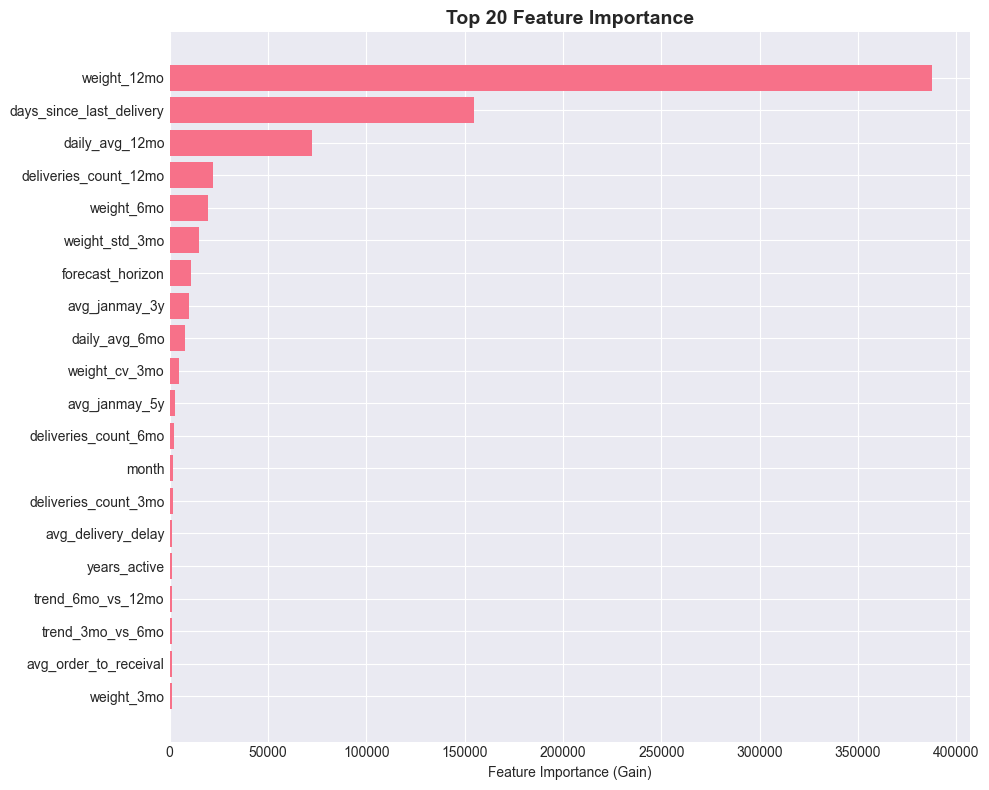

In [52]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model_q20.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

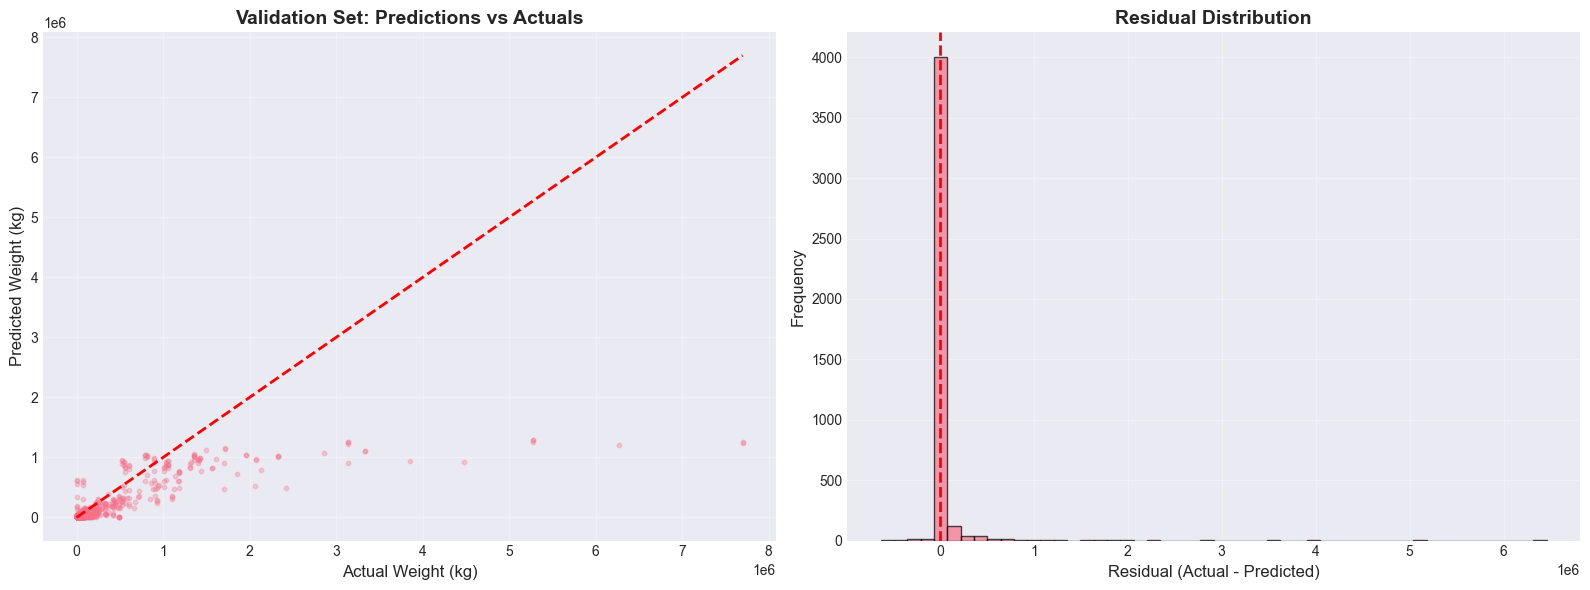


Residual Statistics:
  Mean: 27,692.68
  Median: 0.00
  Std: 240,980.84
  % Underestimated: 14.8%
  % Overestimated: 10.1%


In [53]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation set
axes[0].scatter(y_val, y_pred_val, alpha=0.3, s=10)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Weight (kg)', fontsize=12)
axes[0].set_ylabel('Predicted Weight (kg)', fontsize=12)
axes[0].set_title('Validation Set: Predictions vs Actuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_val - y_pred_val
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():,.2f}")
print(f"  Median: {residuals.median():,.2f}")
print(f"  Std: {residuals.std():,.2f}")
print(f"  % Underestimated: {100 * (residuals > 0).sum() / len(residuals):.1f}%")
print(f"  % Overestimated: {100 * (residuals < 0).sum() / len(residuals):.1f}%")

## 6. Generate Predictions for Test Set

In [56]:
def generate_test_features(prediction_mapping_df, receivals_df, purchase_orders_df):
    """
    Generate features for the test set (2025 predictions).
    
    Parameters:
    - prediction_mapping_df: DataFrame with prediction requirements
    - receivals_df: DataFrame with receival data
    - purchase_orders_df: DataFrame with purchase order data
    
    Returns:
    - DataFrame with features
    """
    print("Generating test features...")
    
    test_data = []
    
    merged_df = receivals_df.merge(purchase_orders_df, on=['purchase_order_id', 'purchase_order_item_no'], how='left', suffixes=('_rm', '_po'))
    
    for idx, row in prediction_mapping_df.iterrows():
        if (idx + 1) % 1000 == 0:
            print(f"  Processed {idx+1:,} / {len(prediction_mapping_df):,} predictions ({100*(idx+1)/len(prediction_mapping_df):.1f}%)")
        
        rm_id = row['rm_id']
        forecast_date = row['forecast_start_date']
        forecast_horizon = row['forecast_horizon']
        
        # Create features
        features = {}
        features['ID'] = row['ID']
        features['rm_id'] = rm_id
        features['forecast_date'] = forecast_date
        features['forecast_horizon'] = forecast_horizon
        
        # Historical features (using all data up to 2024-12-31)
        hist_features = create_historical_features(receivals_df, forecast_date, rm_id)
        features.update(hist_features)
        
        # Purchase order features
        po_features = create_purchase_order_features(merged_df, 
                                                    forecast_date, rm_id)
        
                        # Stability features
        stab_features = create_stability_features(receivals_df, forecast_date, rm_id)
        features.update(stab_features)
        
        features.update(po_features)
        
        # Temporal features
        temp_features = create_temporal_features(forecast_date)
        features.update(temp_features)
        
        test_data.append(features)
    
    print(f"Test feature generation complete: {len(test_data):,} samples")
    return pd.DataFrame(test_data)

In [57]:
# Generate test features
test_df = generate_test_features(prediction_mapping, receivals, purchase_orders)

print(f"\nTest data shape: {test_df.shape}")
print(f"\nTest data preview:")
print(test_df.head())

Generating test features...
  Processed 1,000 / 30,450 predictions (3.3%)
  Processed 2,000 / 30,450 predictions (6.6%)
  Processed 3,000 / 30,450 predictions (9.9%)
  Processed 4,000 / 30,450 predictions (13.1%)
  Processed 5,000 / 30,450 predictions (16.4%)
  Processed 6,000 / 30,450 predictions (19.7%)
  Processed 7,000 / 30,450 predictions (23.0%)
  Processed 8,000 / 30,450 predictions (26.3%)
  Processed 9,000 / 30,450 predictions (29.6%)
  Processed 10,000 / 30,450 predictions (32.8%)
  Processed 11,000 / 30,450 predictions (36.1%)
  Processed 12,000 / 30,450 predictions (39.4%)
  Processed 13,000 / 30,450 predictions (42.7%)
  Processed 14,000 / 30,450 predictions (46.0%)
  Processed 15,000 / 30,450 predictions (49.3%)
  Processed 16,000 / 30,450 predictions (52.5%)
  Processed 17,000 / 30,450 predictions (55.8%)
  Processed 18,000 / 30,450 predictions (59.1%)
  Processed 19,000 / 30,450 predictions (62.4%)
  Processed 20,000 / 30,450 predictions (65.7%)
  Processed 21,000 / 30,

In [58]:
# Prepare test features (same order as training)
X_test = test_df[feature_columns]

print(f"Test feature matrix shape: {X_test.shape}")
print(f"\nMissing values in test features:")
print(X_test.isnull().sum().sum())

Test feature matrix shape: (30450, 47)

Missing values in test features:
66900


In [59]:
# Make predictions
print("Generating predictions...")
predictions = model_q20.predict(X_test, num_iteration=model_q20.best_iteration)

# Ensure non-negative predictions
predictions = np.maximum(0, predictions)

print(f"Predictions generated: {len(predictions):,}")
print(f"\nPrediction statistics:")
print(f"  Min: {predictions.min():,.2f}")
print(f"  Max: {predictions.max():,.2f}")
print(f"  Mean: {predictions.mean():,.2f}")
print(f"  Median: {np.median(predictions):,.2f}")
print(f"  Zero predictions: {(predictions == 0).sum():,} ({100*(predictions == 0).sum()/len(predictions):.1f}%)")

Generating predictions...
Predictions generated: 30,450

Prediction statistics:
  Min: 0.00
  Max: 1,245,205.59
  Mean: 39,698.03
  Median: 0.00
  Zero predictions: 23,086 (75.8%)


## 7. Create Submission File

In [60]:
# Create submission dataframe
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'predicted_weight': predictions
})

# Ensure proper formatting
submission['predicted_weight'] = submission['predicted_weight'].round(2)

print("Submission file preview:")
print(submission.head(20))
print(f"\nSubmission shape: {submission.shape}")

Submission file preview:
    ID  predicted_weight
0    1               0.0
1    2               0.0
2    3               0.0
3    4               0.0
4    5               0.0
5    6               0.0
6    7               0.0
7    8               0.0
8    9               0.0
9   10               0.0
10  11               0.0
11  12               0.0
12  13               0.0
13  14               0.0
14  15               0.0
15  16               0.0
16  17               0.0
17  18               0.0
18  19               0.0
19  20               0.0

Submission shape: (30450, 2)


In [61]:
# Validate submission format
assert list(submission.columns) == ['ID', 'predicted_weight'], "Column names don't match"
assert len(submission) == len(prediction_mapping), f"Row count mismatch: {len(submission)} vs {len(prediction_mapping)}"
assert submission['ID'].equals(prediction_mapping['ID']), "ID mismatch"
assert (submission['predicted_weight'] >= 0).all(), "Negative predictions found"
assert submission['predicted_weight'].isnull().sum() == 0, "Missing predictions found"

print("✓ Submission validation passed!")

✓ Submission validation passed!


In [62]:
# Save submission file
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)
print(f"Submission file saved: {submission_filename}")

Submission file saved: submission.csv


## 8. Analysis and Visualization

In [63]:
# Merge predictions with mapping for analysis
analysis_df = prediction_mapping.merge(submission, on='ID')

# Analyze predictions by horizon
horizon_analysis = analysis_df.groupby('forecast_horizon').agg({
    'predicted_weight': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)

print("Predictions by Forecast Horizon:")
print(horizon_analysis)

Predictions by Forecast Horizon:
                 predicted_weight                                             
                            count      mean median        std  min         max
forecast_horizon                                                              
2                             203   4730.39    0.0   22630.25  0.0   224695.72
3                             203   4730.39    0.0   22630.25  0.0   224695.72
4                             203   4730.39    0.0   22630.25  0.0   224695.72
5                             203   4730.39    0.0   22630.25  0.0   224695.72
6                             203   4730.39    0.0   22630.25  0.0   224695.72
...                           ...       ...    ...        ...  ...         ...
147                           203  58157.87    0.0  213093.74  0.0  1238258.77
148                           203  58157.87    0.0  213093.74  0.0  1238258.77
149                           203  58157.87    0.0  213093.74  0.0  1238258.77
150                

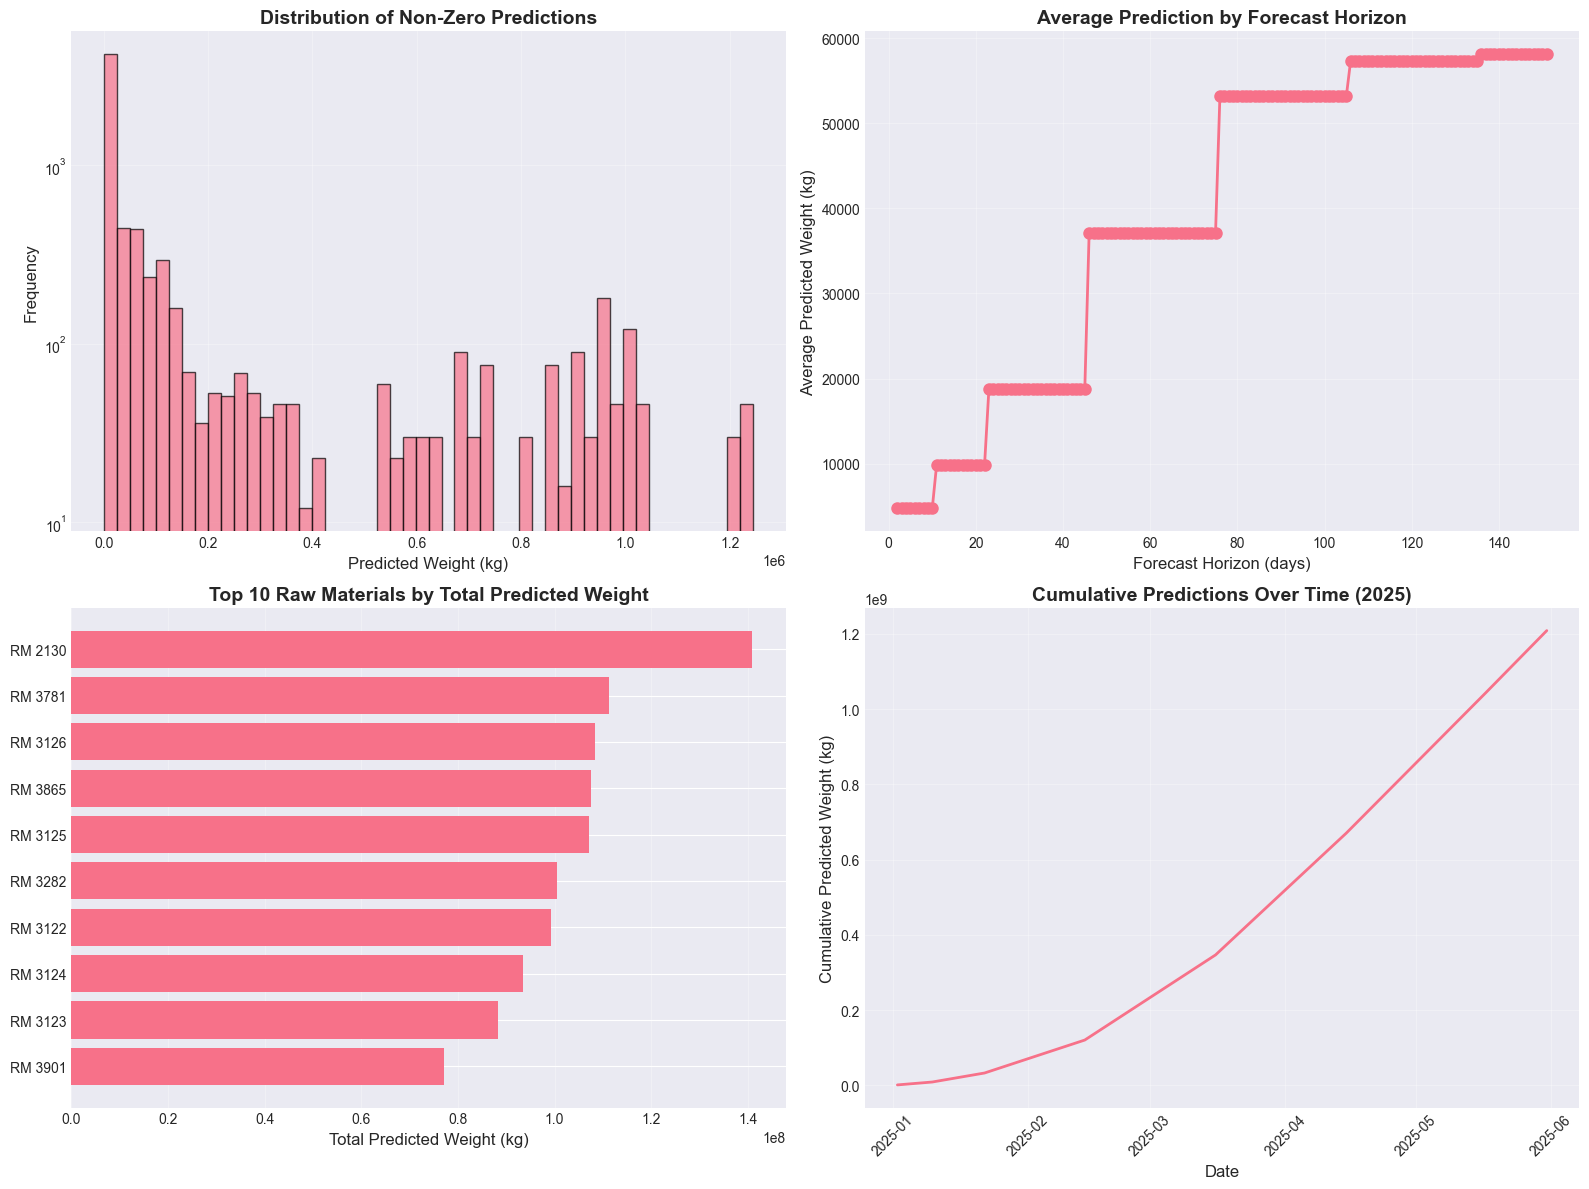

In [64]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of predictions
axes[0, 0].hist(predictions[predictions > 0], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Predicted Weight (kg)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Non-Zero Predictions', fontsize=14, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 2. Predictions by horizon
horizon_means = analysis_df.groupby('forecast_horizon')['predicted_weight'].mean()
axes[0, 1].plot(horizon_means.index, horizon_means.values, marker='o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Forecast Horizon (days)', fontsize=12)
axes[0, 1].set_ylabel('Average Predicted Weight (kg)', fontsize=12)
axes[0, 1].set_title('Average Prediction by Forecast Horizon', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Predictions by raw material (top 10)
top_rm_preds = analysis_df.groupby('rm_id')['predicted_weight'].sum().nlargest(10)
axes[1, 0].barh(range(len(top_rm_preds)), top_rm_preds.values)
axes[1, 0].set_yticks(range(len(top_rm_preds)))
axes[1, 0].set_yticklabels([f"RM {rm}" for rm in top_rm_preds.index])
axes[1, 0].set_xlabel('Total Predicted Weight (kg)', fontsize=12)
axes[1, 0].set_title('Top 10 Raw Materials by Total Predicted Weight', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Cumulative predictions over time
daily_preds = analysis_df.groupby('forecast_end_date')['predicted_weight'].sum().sort_index()
cumulative_preds = daily_preds.cumsum()
axes[1, 1].plot(cumulative_preds.index, cumulative_preds.values, linewidth=2)
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Predicted Weight (kg)', fontsize=12)
axes[1, 1].set_title('Cumulative Predictions Over Time (2025)', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary and Next Steps

In [ ]:
print("="*80)
print("PIPELINE SUMMARY")
print("="*80)
print(f"\nData Processing:")
print(f"  - Training samples: {len(train_df):,}")
print(f"  - Test samples: {len(test_df):,}")
print(f"  - Features used: {len(feature_columns)}")
print(f"\nModel Performance (Validation):")
print(f"  - Quantile Loss (0.2): {val_metrics['quantile_loss']:,.2f}")
print(f"  - MAE: {val_metrics['mae']:,.2f}")
print(f"  - RMSE: {val_metrics['rmse']:,.2f}")
print(f"\nPredictions:")
print(f"  - Total predictions: {len(predictions):,}")
print(f"  - Non-zero predictions: {(predictions > 0).sum():,} ({100*(predictions > 0).sum()/len(predictions):.1f}%)")
print(f"  - Mean prediction: {predictions.mean():,.2f} kg")
print(f"  - Total predicted weight: {predictions.sum():,.2f} kg")
print(f"\nOutput Files:")
print(f"  - Submission: {submission_filename}")
print(f"  - Training data: training_data.csv")
print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("1. Review feature importance and consider additional features")
print("2. Experiment with different quantile levels (try 0.15 or 0.25)")
print("3. Try ensemble methods (combine multiple quantile models)")
print("4. Analyze prediction errors by raw material and horizon")
print("5. Submit to Kaggle and iterate based on leaderboard feedback")
print("="*80)